In [5]:
all_sites_db = (
    "/Volumes/Tungsten/Projects/25:11:23 - mako_model_testing/all_sites.duckdb"
)
model_results_tsv = (
    "/Volumes/Tungsten/Projects/25:11:23 - mako_model_testing/merged.tsv"
)

In [ ]:
import pandas as pd
import numpy as np
import duckdb
import matplotlib.pyplot as plt
import seaborn as sns

: 

## Loading data

In [ ]:
conn = duckdb.connect(all_sites_db, read_only=True)
reads = conn.execute("SELECT * FROM reads").df()

model_fits = pd.read_csv(model_results_tsv, sep="\t")

In [ ]:
reads

,sample_name,group_name,transcript_id,transcript_position,probability_modified
0,H2228,adenocarcinoma,ENST00000040738.10|ENSG00000038219.13|OTTHUMG0...,6012,0.001953
1,H2228,adenocarcinoma,ENST00000040738.10|ENSG00000038219.13|OTTHUMG0...,6012,0.005859
2,H2228,adenocarcinoma,ENST00000040738.10|ENSG00000038219.13|OTTHUMG0...,6012,0.001953
3,H2228,adenocarcinoma,ENST00000040738.10|ENSG00000038219.13|OTTHUMG0...,6012,0.001953
4,H2228,adenocarcinoma,ENST00000040738.10|ENSG00000038219.13|OTTHUMG0...,6012,0.001953
...,...,...,...,...,...
2392270,H69,sclc_a,ENST00000710305.1|ENSG00000292244.1|-|-|ENST00...,1846,0.001953
2392271,H69,sclc_a,ENST00000710305.1|ENSG00000292244.1|-|-|ENST00...,1846,0.001953
2392272,H69,sclc_a,ENST00000710305.1|ENSG00000292244.1|-|-|ENST00...,1846,0.001953
2392273,H69,sclc_a,ENST00000710305.1|ENSG00000292244.1|-|-|ENST00...,1846,0.708984


In [ ]:
model_fits

,estimate,p_value,transcript_id,transcript_position
0,0.002014,0.977115,ENST00000040738.10|ENSG00000038219.13|OTTHUMG0...,6012
1,-0.000870,0.988907,ENST00000066544.8|ENSG00000004897.12|OTTHUMG00...,1868
2,-0.133193,0.190270,ENST00000052569.10|ENSG00000047932.14|OTTHUMG0...,928
3,0.042991,0.499432,ENST00000176763.10|ENSG00000072786.13|OTTHUMG0...,1922
4,0.000155,0.998019,ENST00000013125.9|ENSG00000012983.12|OTTHUMG00...,1193
...,...,...,...,...
1995,1.848189,0.066742,ENST00000622155.4|ENSG00000163214.21|OTTHUMG00...,950
1996,0.176630,0.301060,ENST00000677037.1|ENSG00000122566.23|OTTHUMG00...,1473
1997,-0.373630,0.045176,ENST00000677075.1|ENSG00000122566.23|OTTHUMG00...,1729
1998,-0.010442,0.954241,ENST00000689217.1|ENSG00000009307.17|OTTHUMG00...,2276


## Recommended post-processing of model fitting/differential analysis results

In [ ]:
# Function for computing Benjamini-Hochberg corrected p-values for multiple testing FDR control
from statsmodels.stats.multitest import multipletests


def add_bh_corrected_pvalues(df, pval_col="p_value", alpha=0.05):
    """
    Returns a new DataFrame with an added column for BH-corrected p-values.

    Parameters:
    -----------
    df : pandas.DataFrame
        Original DataFrame containing p-values.
    pval_col : str, default='p_value'
        Name of the column with raw p-values.
    alpha : float, default=0.05
        Significance level for the BH correction (multipletests alpha).

    Returns:
    --------
    df_new : pandas.DataFrame
        Copy of original df with a new column 'bh_corrected_p_value'.
    """
    df_new = df.copy()
    df_new["bh_corrected_p_value"] = np.nan

    non_na_idx = df_new[pval_col].notna()
    if non_na_idx.any():
        _, bh_pvals, _, _ = multipletests(
            df_new.loc[non_na_idx, pval_col].values, alpha=alpha, method="fdr_bh"
        )
        df_new.loc[non_na_idx, "bh_corrected_p_value"] = bh_pvals

    return df_new

In [ ]:
model_fits_with_bh_corrected_pvalues = add_bh_corrected_pvalues(model_fits)
model_fits_with_bh_corrected_pvalues

,estimate,p_value,transcript_id,transcript_position,bh_corrected_p_value
0,0.002014,0.977115,ENST00000040738.10|ENSG00000038219.13|OTTHUMG0...,6012,0.995829
1,-0.000870,0.988907,ENST00000066544.8|ENSG00000004897.12|OTTHUMG00...,1868,0.997933
2,-0.133193,0.190270,ENST00000052569.10|ENSG00000047932.14|OTTHUMG0...,928,0.562928
3,0.042991,0.499432,ENST00000176763.10|ENSG00000072786.13|OTTHUMG0...,1922,0.834912
4,0.000155,0.998019,ENST00000013125.9|ENSG00000012983.12|OTTHUMG00...,1193,0.999888
...,...,...,...,...,...
1995,1.848189,0.066742,ENST00000622155.4|ENSG00000163214.21|OTTHUMG00...,950,0.306155
1996,0.176630,0.301060,ENST00000677037.1|ENSG00000122566.23|OTTHUMG00...,1473,0.680567
1997,-0.373630,0.045176,ENST00000677075.1|ENSG00000122566.23|OTTHUMG00...,1729,0.237070
1998,-0.010442,0.954241,ENST00000689217.1|ENSG00000009307.17|OTTHUMG00...,2276,0.994202


## Some visualisations

### Visualisations of modification called data

In [ ]:
def plot_read_distributions(df, bins=50):
    """
    Combined plotting of read distributions:
    1. Histogram of reads per transcript site (raw and log10)
    2. Histogram of reads per sample-site combination (raw and log10)
    3. Histogram of reads per group-site combination (raw and log10)

    Parameters:
    -----------
    df : pandas.DataFrame
        Must contain columns: sample_name, group_name, transcript_id, transcript_position
    bins : int, default=50
        Number of bins in the histograms
    """
    fig, axes = plt.subplots(3, 2, figsize=(14, 14))

    # ==========================
    # Row 1: Reads per transcript site
    # ==========================
    site_counts = df.groupby(["transcript_id", "transcript_position"]).size()

    axes[0, 0].hist(site_counts, bins=bins, edgecolor="black", color="skyblue")
    axes[0, 0].set_title("Reads per Transcript Site")
    axes[0, 0].set_xlabel("Number of reads per site")
    axes[0, 0].set_ylabel("Number of transcript sites")
    axes[0, 0].grid(True, linestyle="--", alpha=0.6)

    log_counts = np.log10(site_counts)
    axes[0, 1].hist(log_counts, bins=bins, edgecolor="black", color="skyblue")
    axes[0, 1].set_title("Reads per Transcript Site (log10)")
    axes[0, 1].set_xlabel("log10(Number of reads per site)")
    axes[0, 1].set_ylabel("Number of transcript sites")
    axes[0, 1].grid(True, linestyle="--", alpha=0.6)

    xticks = axes[0, 1].get_xticks()
    raw_ticks = np.round(10**xticks).astype(int)
    secax = axes[0, 1].secondary_xaxis("top")
    secax.set_xticks(xticks)
    secax.set_xticklabels(raw_ticks)
    secax.set_xlabel("Number of reads")

    # ==========================
    # Row 2: Reads per sample-site
    # ==========================
    sample_site_counts = df.groupby(
        ["sample_name", "transcript_id", "transcript_position"]
    ).size()

    axes[1, 0].hist(sample_site_counts, bins=bins, edgecolor="black", color="skyblue")
    axes[1, 0].set_title("Reads per Sample-Site")
    axes[1, 0].set_xlabel("Number of reads per sample-site")
    axes[1, 0].set_ylabel("Number of sample-site combinations")
    axes[1, 0].grid(True, linestyle="--", alpha=0.6)

    log_counts = np.log10(sample_site_counts)
    axes[1, 1].hist(log_counts, bins=bins, edgecolor="black", color="skyblue")
    axes[1, 1].set_title("Reads per Sample-Site (log10)")
    axes[1, 1].set_xlabel("log10(Number of reads per sample-site)")
    axes[1, 1].set_ylabel("Number of sample-site combinations")
    axes[1, 1].grid(True, linestyle="--", alpha=0.6)

    xticks = axes[1, 1].get_xticks()
    raw_ticks = np.round(10**xticks).astype(int)
    secax = axes[1, 1].secondary_xaxis("top")
    secax.set_xticks(xticks)
    secax.set_xticklabels(raw_ticks)
    secax.set_xlabel("Number of reads")

    # ==========================
    # Row 3: Reads per group-site
    # ==========================
    group_site_counts = df.groupby(
        ["group_name", "transcript_id", "transcript_position"]
    ).size()

    axes[2, 0].hist(group_site_counts, bins=bins, edgecolor="black", color="skyblue")
    axes[2, 0].set_title("Reads per Group-Site")
    axes[2, 0].set_xlabel("Number of reads per group-site")
    axes[2, 0].set_ylabel("Number of group-site combinations")
    axes[2, 0].grid(True, linestyle="--", alpha=0.6)

    log_counts = np.log10(group_site_counts)
    axes[2, 1].hist(log_counts, bins=bins, edgecolor="black", color="skyblue")
    axes[2, 1].set_title("Reads per Group-Site (log10)")
    axes[2, 1].set_xlabel("log10(Number of reads per group-site)")
    axes[2, 1].set_ylabel("Number of group-site combinations")
    axes[2, 1].grid(True, linestyle="--", alpha=0.6)

    xticks = axes[2, 1].get_xticks()
    raw_ticks = np.round(10**xticks).astype(int)
    secax = axes[2, 1].secondary_xaxis("top")
    secax.set_xticks(xticks)
    secax.set_xticklabels(raw_ticks)
    secax.set_xlabel("Number of reads")

    plt.tight_layout()
    plt.show()

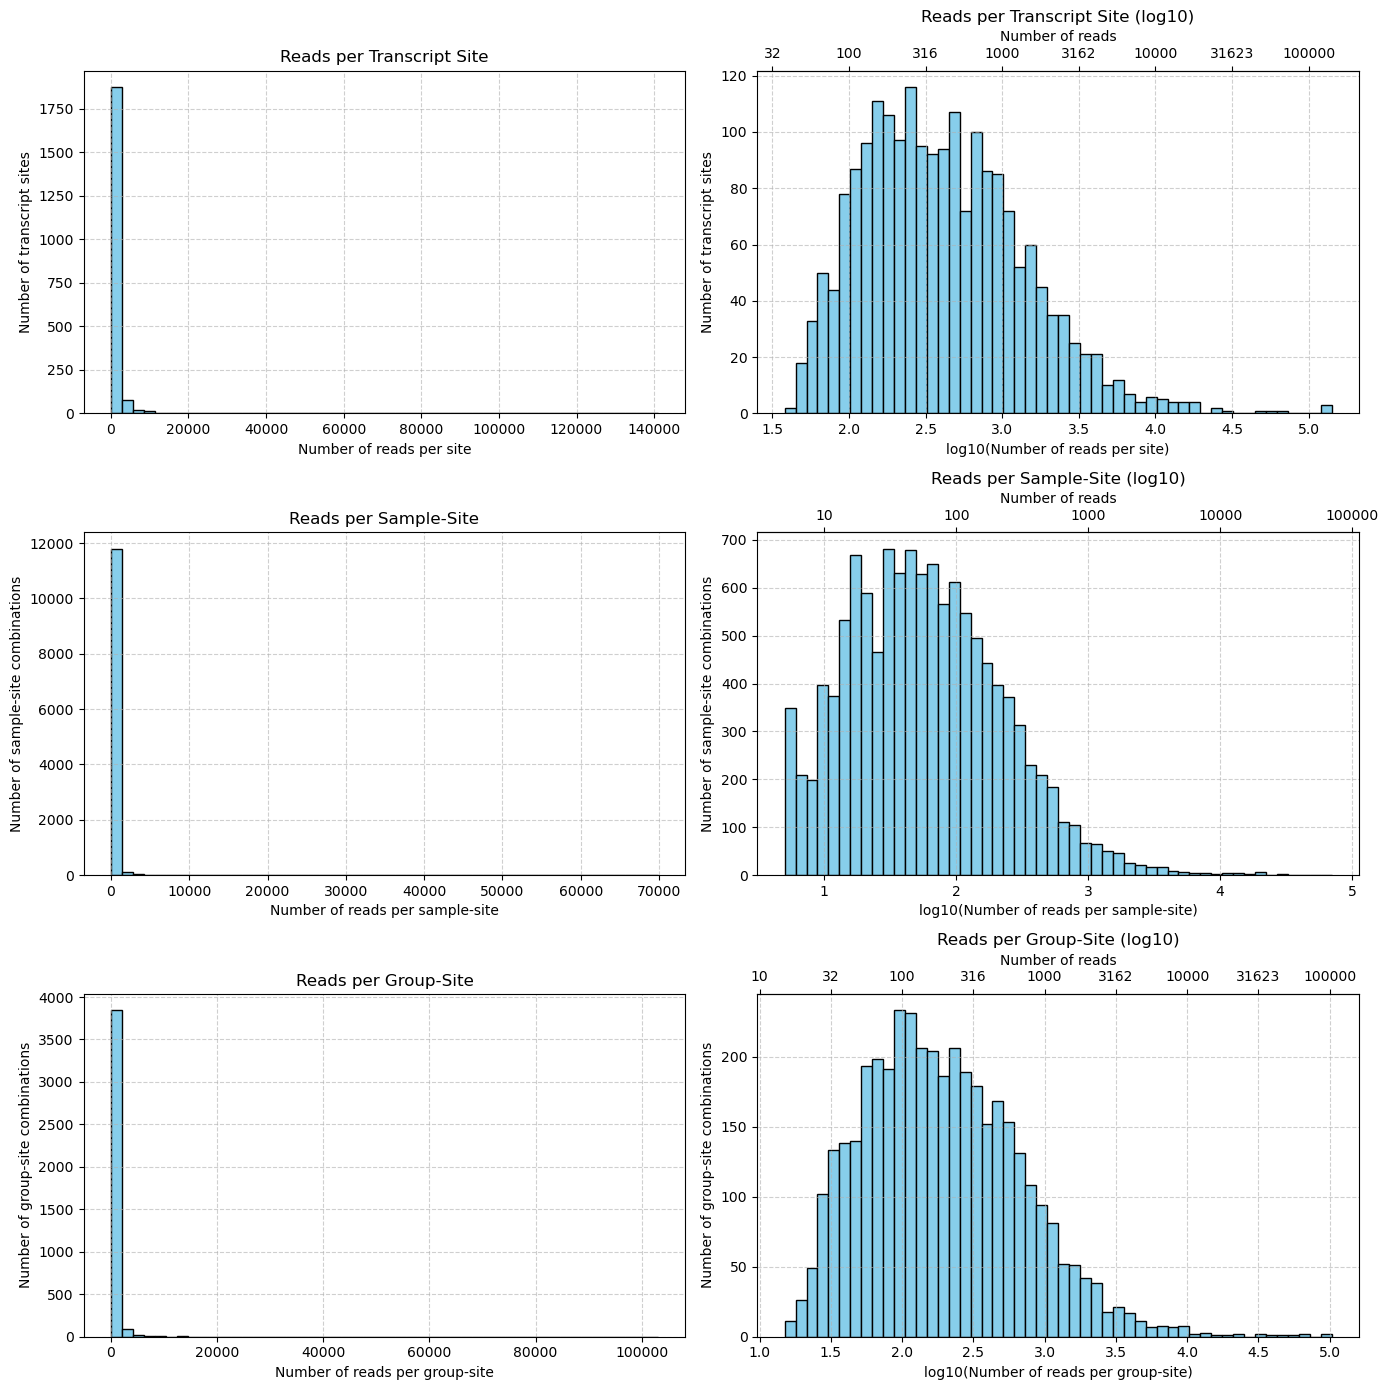

In [ ]:
plot_read_distributions(reads)

In [ ]:
def plot_site_sample_counts_bar(df):
    """
    Plot distribution of number of samples per transcript site as a bar chart.

    A site is defined as a unique combination of 'transcript_id' and 'transcript_position'.
    The number of samples is counted as the number of unique 'sample_name's per site.

    Parameters:
    -----------
    df : pandas.DataFrame
        Must contain columns: sample_name, transcript_id, transcript_position
    """

    # Count number of unique samples per site
    site_sample_counts = df.groupby(["transcript_id", "transcript_position"])[
        "sample_name"
    ].nunique()

    # Describe
    desc = site_sample_counts.describe()
    formatted_desc = desc.apply(lambda x: f"{x:.2f}")
    print("Descriptive statistics of number of samples per site:")
    print(formatted_desc)

    # Count frequency of each integer number of samples
    counts = site_sample_counts.value_counts().sort_index()

    # If there is only one unique value, ensure it's still plotted as a bar
    if len(counts) == 1:
        x = counts.index.values
        y = counts.values
        plt.bar(x, y, color="skyblue", edgecolor="black", width=0.6)
        plt.xticks(x)
    else:
        x = counts.index.values
        y = counts.values
        plt.bar(x, y, color="skyblue", edgecolor="black", width=0.6)

    plt.xlabel("Number of unique samples per site")
    plt.ylabel("Number of transcript sites")
    plt.title("Distribution of Samples per Transcript Site")
    plt.grid(True, linestyle="--", alpha=0.6, axis="y")
    plt.tight_layout()
    plt.show()

Descriptive statistics of number of samples per site:
count    2000.00
mean        6.00
std         0.00
min         6.00
25%         6.00
50%         6.00
75%         6.00
max         6.00
Name: sample_name, dtype: object


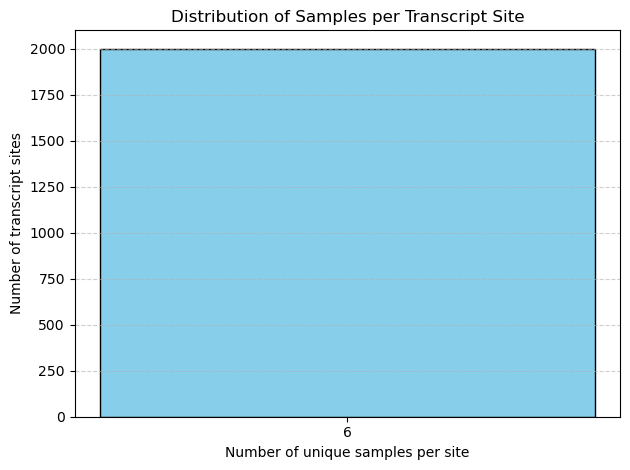

In [ ]:
plot_site_sample_counts_bar(reads)

In [ ]:
def plot_violin_by_site(reads, transcript_id, transcript_position):
    # Subset reads for this site
    subset = reads[
        (reads["transcript_id"] == transcript_id)
        & (reads["transcript_position"] == transcript_position)
    ].copy()

    if subset.empty:
        print(f"No matching reads found for ({transcript_id}, {transcript_position})")
        return

    # Add combined label and sort
    subset["label"] = subset["sample_name"] + " (" + subset["group_name"] + ")"
    subset.sort_values(["group_name", "sample_name"], inplace=True)
    label_order = subset["label"].unique()

    # Compute logit-transformed probability
    eps = 1e-10
    subset["logit_prob"] = np.log(
        (subset["probability_modified"] + eps)
        / (1 - subset["probability_modified"] + eps)
    )

    # Compute counts per label for display
    counts = subset.groupby("label").size().reindex(label_order)
    label_order_with_n = [f"{lbl}\n(n={counts[lbl]})" for lbl in label_order]

    # Plot side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(max(16, len(label_order) * 1.5), 8))

    def plot_violin(ax, y, y_label, clip_0_1=False, apply_cut=False):
        # Only pass 'cut' if apply_cut=True
        violin_kwargs = dict(
            data=subset,
            x="label",
            y=y,
            order=label_order,
            inner=None,
            density_norm="width",
            color="skyblue",
            ax=ax,
        )
        if apply_cut:
            violin_kwargs["cut"] = 0
        sns.violinplot(**violin_kwargs)

        sns.boxplot(
            data=subset,
            x="label",
            y=y,
            order=label_order,
            showcaps=True,
            width=0.15,
            boxprops={"facecolor": "white", "edgecolor": "black", "linewidth": 1},
            whiskerprops={"color": "black", "linewidth": 1},
            capprops={"color": "black", "linewidth": 1},
            medianprops={"color": "black", "linewidth": 1},
            showfliers=False,
            ax=ax,
        )
        sns.stripplot(
            data=subset,
            x="label",
            y=y,
            order=label_order,
            color="black",
            size=2,
            jitter=True,
            alpha=0.5,
            ax=ax,
        )

        stats = subset.groupby("label")[y].agg(["mean", "std"]).reindex(label_order)
        for j, label in enumerate(label_order):
            mean_val = stats.loc[label, "mean"]
            std_val = stats.loc[label, "std"]
            ax.plot(j, mean_val, "o", color="red", markersize=6)

            if clip_0_1:
                ymin = max(0, mean_val - std_val)
                ymax = min(1, mean_val + std_val)
                ax.errorbar(
                    j,
                    mean_val,
                    yerr=[[mean_val - ymin], [ymax - mean_val]],
                    fmt="none",
                    ecolor="red",
                    elinewidth=1,
                    capsize=5,
                )
            else:
                ax.errorbar(
                    j,
                    mean_val,
                    yerr=std_val,
                    fmt="none",
                    ecolor="red",
                    elinewidth=1,
                    capsize=5,
                )

        ax.set_xticks(range(len(label_order)))
        ax.set_xticklabels(label_order_with_n, rotation=45, ha="right")
        ax.set_xlabel("Sample (Group)")
        ax.set_ylabel(y_label)
        ax.set_title(f"Violin Plot of {y_label} for each Sample")
        ax.grid(True, linestyle="--", alpha=0.6)

    # Left: raw probability (cut violin and clip error bars)
    plot_violin(
        axes[0],
        "probability_modified",
        "Probability Modified",
        clip_0_1=True,
        apply_cut=True,
    )
    # Right: logit (default behavior, no cut, no clipping)
    plot_violin(
        axes[1],
        "logit_prob",
        "Logit(Probability Modified)",
        clip_0_1=False,
        apply_cut=False,
    )

    plt.suptitle(
        f"Transcript: {transcript_id}, Position: {transcript_position}", fontsize=16
    )
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

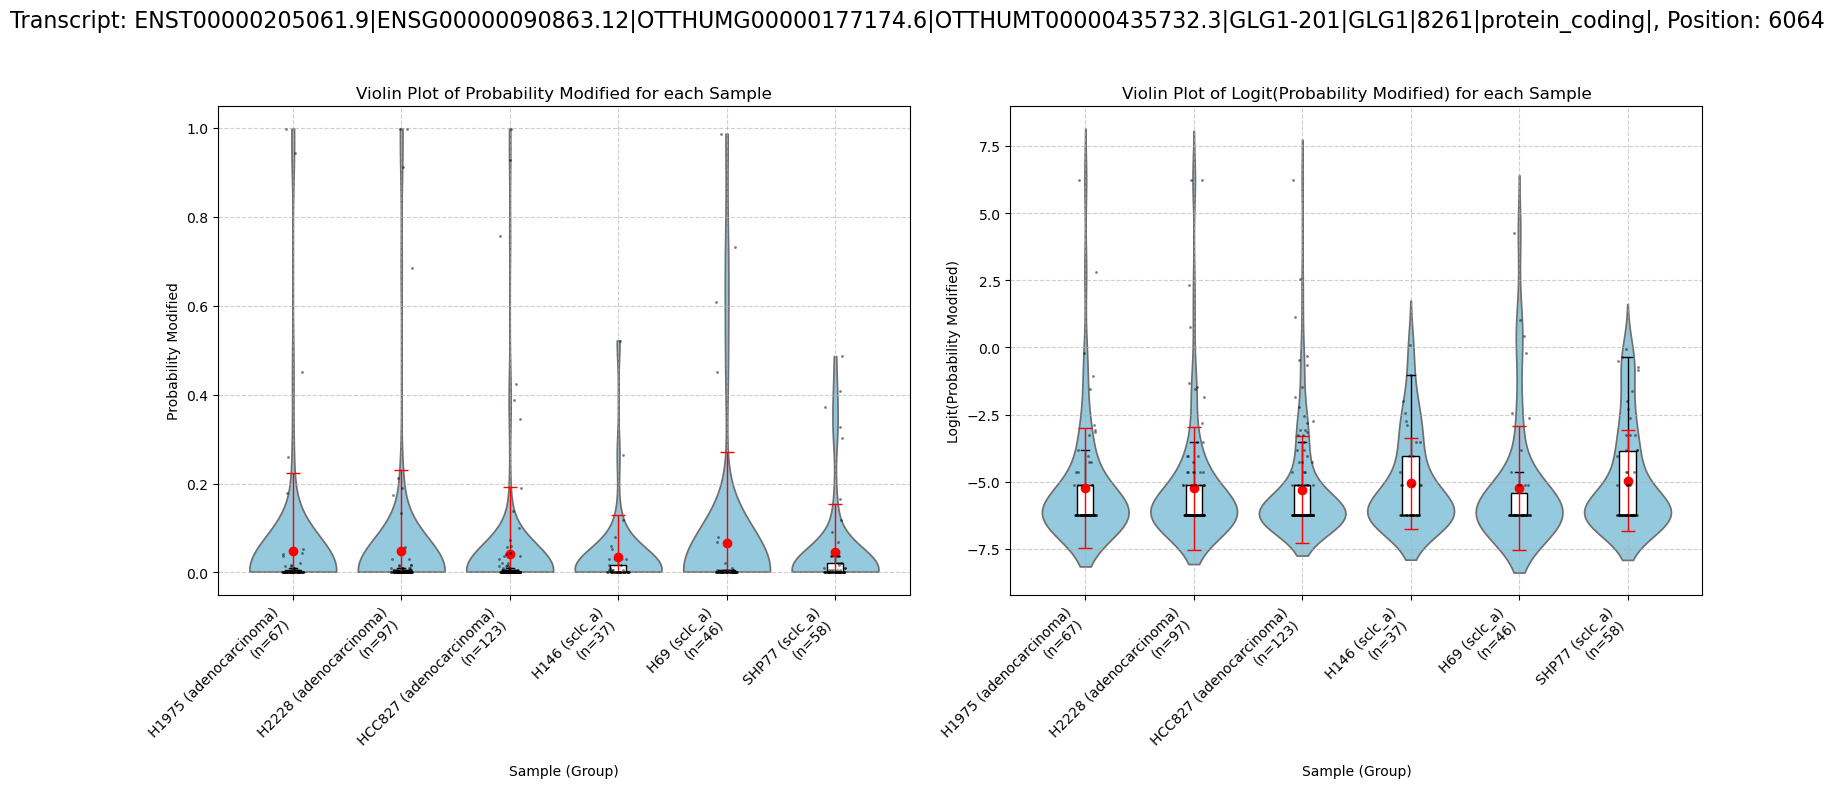

In [ ]:
unique_sites = reads[["transcript_id", "transcript_position"]].drop_duplicates()
selected_site = unique_sites.iloc[15]
transcript_id = selected_site["transcript_id"]
transcript_position = selected_site["transcript_position"]

plot_violin_by_site(reads, transcript_id, transcript_position)

### Visualisations for model fitting/differential analysis results

In [ ]:
def plot_pvalue_histogram(df, pval_col="p_value", bins=50):
    """
    Plots a histogram of raw p-values on the original scale.

    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame containing the p-values.
    pval_col : str, default='p_value'
        Name of the column with p-values to plot
    bins : int, default=50
        Number of bins in the histogram.
    """

    # Drop NA values
    pvals = df[pval_col].dropna().copy()

    # Count zeros and ones
    zero_count = (pvals == 0).sum()
    one_count = (pvals == 1).sum()

    # Create histogram plot
    fig, ax = plt.subplots(figsize=(6, 5))
    ax.hist(pvals, bins=bins, color="skyblue", edgecolor="black")
    ax.set_title("Histogram of p-values")
    ax.set_xlabel("p-value")
    ax.set_ylabel("Frequency")

    # Annotate zeros and ones if present
    text = []
    if zero_count > 0:
        text.append(f"{zero_count} zeros")
    if one_count > 0:
        text.append(f"{one_count} ones")
    if text:
        ax.text(
            0.05,
            0.95,
            "\n".join(text),
            transform=ax.transAxes,
            fontsize=10,
            verticalalignment="top",
            bbox=dict(facecolor="white", alpha=0.6, edgecolor="none"),
        )

    plt.tight_layout()
    plt.show()

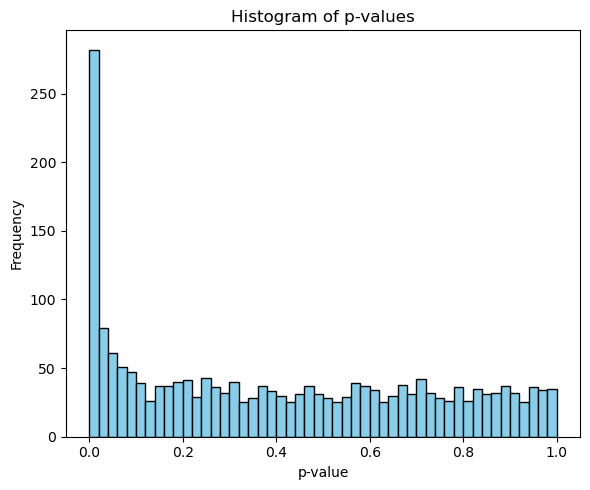

In [ ]:
plot_pvalue_histogram(model_fits, pval_col="p_value")
# plot_pvalue_histogram(model_fits_with_bh_corrected_pvalues, pval_col='bh_corrected_p_value')

In [ ]:
def plot_pvalue_cdf(df, pval_col="p_value"):
    """
    Plots the empirical cumulative distribution (CDF) of p-values.

    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame containing the p-values.
    pval_col : str, default='p_value'
        Name of the column with p-values to plot
    """

    # Drop NA values
    pvals = df[pval_col].dropna().copy()

    # Sort p-values for CDF
    sorted_pvals = np.sort(pvals)
    n = len(sorted_pvals)
    cdf = np.linspace(0, 1, n)

    # Create plot
    fig, ax = plt.subplots(figsize=(6, 5))
    ax.plot(sorted_pvals, cdf, color="steelblue", lw=2)

    ax.set_title("CDF of p-values")
    ax.set_xlabel("p-value")
    ax.set_ylabel("Cumulative Proportion")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.grid(True, linestyle="--", alpha=0.6)

    plt.tight_layout()
    plt.show()

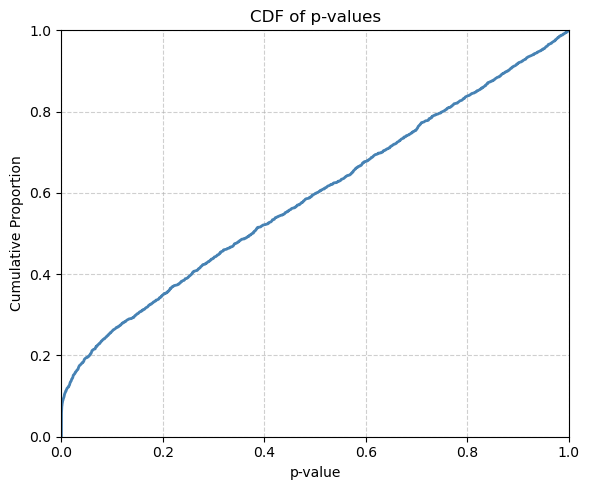

In [ ]:
plot_pvalue_cdf(model_fits, pval_col="p_value")
# plot_pvalue_cdf(model_fits_with_bh_corrected_pvalues, pval_col="bh_corrected_p_value")

In [ ]:
def plot_bh_discoveries(df, pval_col="p_value", alpha_range=(0, 0.2), num_points=200):
    """
    Plot number of BH-corrected discoveries vs FDR threshold (alpha) for a single model.
    Includes secondary y-axis showing discoveries as percentage of total sites (including NAs).

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing p-values in column `pval_col`.
    pval_col : str, default='p_value'
        Name of the column containing raw p-values.
    alpha_range : tuple of float, default=(0, 0.2)
        Range of FDR thresholds (min_alpha, max_alpha) to consider. Must be within [0,1].
    num_points : int, default=200
        Number of alpha points between min and max to evaluate.
    """

    # Validate alpha range
    min_alpha, max_alpha = alpha_range
    assert 0 <= min_alpha <= 1, "Minimum alpha must be in [0,1]"
    assert 0 <= max_alpha <= 1, "Maximum alpha must be in [0,1]"
    assert min_alpha < max_alpha, "Minimum alpha must be less than maximum alpha"

    # Total number of sites (including NA)
    total_sites = len(df)

    # Drop NA p-values for BH calculation
    pvals = df[pval_col].dropna().values

    # Create FDR threshold grid
    alphas = np.linspace(min_alpha, max_alpha, num_points)
    discoveries = []

    for alpha in alphas:
        reject, corrected_pvals, _, _ = multipletests(
            pvals, alpha=alpha, method="fdr_bh"
        )
        discoveries.append((corrected_pvals <= alpha).sum())

    discoveries = np.array(discoveries)

    # Plot discoveries vs FDR threshold
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(alphas, discoveries, color="steelblue", lw=2)
    ax.set_xlabel("FDR threshold (alpha)")
    ax.set_ylabel("Number of significant discoveries", color="black")
    ax.tick_params(axis="y", labelcolor="black")
    ax.grid(True)

    # Secondary axis: scaled linearly to percent of total sites
    def to_percent(x):
        return 100 * x / total_sites

    def to_count(y):
        return y * total_sites / 100

    secax = ax.secondary_yaxis("right", functions=(to_percent, to_count))
    secax.set_ylabel("Discoveries (% of total sites)", color="black")
    secax.tick_params(axis="y", labelcolor="black")

    plt.title("BH-corrected discoveries vs FDR threshold")
    plt.tight_layout()
    plt.show()

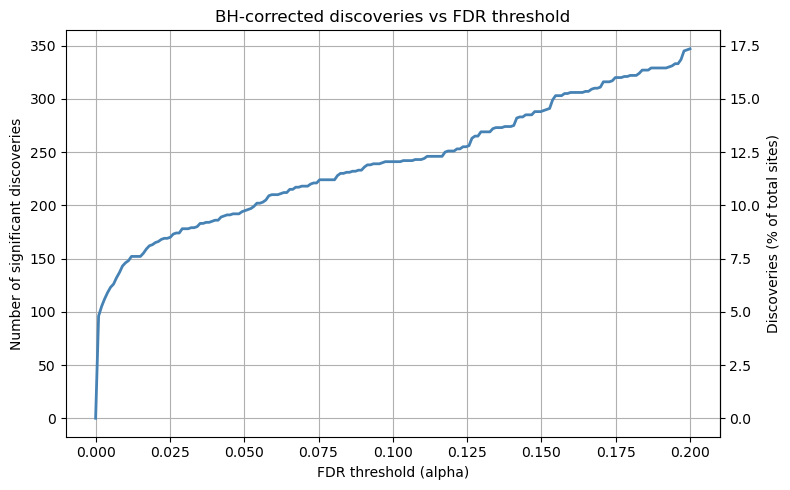

In [ ]:
plot_bh_discoveries(model_fits)